# Getting started

👋 Welcome to Deepnote! If you're new to notebooks, we recommend you browse through this guide and watch the videos (it takes about 5 minutes). You can also pick what's most relevant to you right now and come back anytime to see the rest. 

## 1. Run a cell 🏃
Select the code cell below and click _Run_ in the right sidebar. You can also press <kbd>Shift</kbd>+<kbd>Enter</kbd> to run it and move to the next cell.

![Picture title](image-20210902-230946.png)

Ideas: Introducimos la data en un Pandas. Iteramos sobre las columnas y analizamos los valores posibles para cada columna, incluyendo la clase de cada caso. Podemos crear luego un objeto que sea conjunto o algo asi, y ese objeto le damos el metodo "entropia". Aparte, creamos una funcion que reciba uno de estos conjuntos y tome los atributos que analizamos de la tabla. La funcion itera sobre la lista de atributos y nos devuelve el atributo con mayor ganancia
Ahi miramos si tenemos suficiente ganancia, sit enemos, creamos un nodo y separamos cada caso dependiendo del valor del atributo en subconjuntos. Guardamos los subconjuntos en una lista en el nodo y llamamos al algoritmo con los elementos de la lista.

In [1]:
!pip install streamlit

     |████████████████████████████████| 8.0 MB 8.2 MB/s 
     |████████████████████████████████| 180 kB 38.1 MB/s 
     |████████████████████████████████| 4.3 MB 35.4 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 111 kB 11.5 MB/s 
     |████████████████████████████████| 63 kB 868 kB/s 
     |████████████████████████████████| 121 kB 36.4 MB/s 
     |████████████████████████████████| 243 kB 39.3 MB/s 
     |████████████████████████████████| 2.2 MB 9.8 MB/s 
     |████████████████████████████████| 70 kB 4.5 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=b0398cf44d2d83725ba177716848c1e35d99027a2a138441d59b6711c3889f73
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install graphviz

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import math
import streamlit as st
import graphviz as graphviz

2021-09-18 12:24:01.600 INFO    matplotlib.font_manager: generated new fontManager


In [4]:
df = pd.read_csv('data_test.csv')
df.head(15)

,Hipertenso,Colesterol,Trigliceridos,Edad,Diabeico,ProblemasCardiacos
0,F,bajo,normal,menos_40,T,F
1,T,bajo,elevado,menos_40,T,F
2,T,bajo,elevado,mayor_60,T,T
3,T,medio,elevado,mayor_60,F,T
4,F,medio,elevado,menos_40,F,T
5,F,medio,normal,entre_40_60,T,F
6,T,alto,normal,entre_40_60,T,T
7,T,alto,normal,entre_40_60,T,T
8,T,alto,elevado,mayor_60,F,T
9,F,alto,normal,menos_40,F,F


In [5]:
df['ProblemasCardiacos'].mode().item()

'T'

![Picture title](entropy.png)


![Picture title](entropyAt.png)

In [6]:
classValues = list(df['ProblemasCardiacos'].value_counts().index) # Valores posibles de la columna clase
classValues

['T', 'F']

In [7]:
class SetCases:
    def __init__(self,cases,case_count,class_column_name):
        self.cases = cases
        self.class_column_name = class_column_name
        self.case_count = case_count
        self.columns = list(cases.columns)
        #self.attributes = self.columns
        self.attributes = [item for item in self.columns if item != self.class_column_name] # This is 'A' in the theory
        #self.attributes.remove(self.class_column_name)  
    def cases_count(self):
        self.case_count = self.cases.shape[0]
        return self.case_count
        
    def get_attributes(self) -> list:
        return self.attributes
    
    def entropy(self) -> float:  # Entropy Formula function
        entropy = 0
        counts = self.cases[self.class_column_name].value_counts()
        for item in classValues:
            prob = self.cases[self.cases[self.class_column_name]==item][self.class_column_name].count()/self.case_count
            entropy -= (prob)*(math.log2(prob))
        return round(entropy,3)

    def entropy_attribute(self) -> float: # Entropia de cada tributo de 'A'
        entropy_result = {}
        for attribute in self.attributes:  # Bucle sobre cada atributo de la lista
            result = 0
            attr_indexes = list(self.cases[attribute].value_counts().index)
            attr_counts = list(self.cases[attribute].value_counts().values)
            i=0
            for value in attr_indexes: # Bucle sobre los valores posibles de cada atributo
                attr_entropy = 0
                attr_count = attr_counts[i]

                for c_value in classValues: # Bucle sobre cada caso de un valor posible de un atributo
                    class_count = len(self.cases[(self.cases[attribute]==value)&(self.cases[self.class_column_name]==c_value)])
                    if class_count != 0:
                        attr_entropy -= (class_count/attr_count) * (math.log2((class_count/attr_count)))
                    else:
                        attr_entropy -= 0 #ESTO SE TENDRIA QUE SACAR DE ACA, CUANDO ESTE EL CODIGO COMPLETO ESTO IRIA AL PRINCIPIO
                i+=1

                result += (attr_count/self.case_count) * attr_entropy # Resultado de entropia de un atributo posible
            entropy_result[attribute] = result
        return entropy_result

    def gain(self) -> list: # return [Att, Value]
        entropy = self.entropy()
        entropy_atts = self.entropy_attribute()
        max_gain = 0
        curr_gain = 0
        result = [0,0]
        for key,value in entropy_atts.items():
            curr_gain = float(entropy) - value 
            if curr_gain > max_gain:
                max_gain = curr_gain
                result[0] = key
                result[1] = curr_gain
        return result
    
    def is_pure(self) -> bool:
        classes = self.cases[self.class_column_name].unique()
        if len(classes) == 1:
            return True
        return False
    
    def most_frequent_class(self) -> str:
        return self.cases[self.class_column_name].mode().item()
    
    def separate_data(self, attr) -> list: # Esto retorna un arreglo con dataframes
        attr_values = list(self.cases[attr].unique())
        frames = []
        for val in attr_values:
            frames.append(self.cases[self.cases[attr]==val])
        return frames

In [255]:
name_counter = 1

In [256]:
class Node:
    def __init__(self, data: SetCases, id_node: int):
        self.data = data
        self.children = []
        self.curr_class = ''
        self.chosen_att = ''
        self.id_node = id_node
        global name_counter

    def addChildren(self, node):
        self.children.append(node)
        
    def printTree(self, depth: int, graph, previous_node: Node, name_previous_node: int):
        print('###############################################')
        print(f"Depth {depth}")
        print(self.curr_class)
        global name_counter
        if self.chosen_att != '':
            print(f'Created node with name {self.id_node} and label {self.chosen_att}')
            graph.node(name = str(self.id_node),label = self.chosen_att)
        else:
            print(f'Created node with name {self.id_node} and label {self.curr_class}')
            graph.node(name = str(self.id_node), label= self.curr_class,color='green')
        if depth != 0:
            print(f'Created edge between {name_previous_node} and {self.id_node}')
            graph.edge(str(name_previous_node), str(self.id_node))
        #name_counter+=1
        name_previous_node+=1
        for item in self.children:
            item.printTree(depth+1, graph, self, self.id_node)
        

In [257]:
def decisionTree(D : SetCases, A : list, T : Node, guide_int : int):
    global name_counter
    if D.is_pure():
        class_name = D.most_frequent_class()
        T.curr_class = class_name
    elif not A:
        class_name = D.most_frequent_class()
        T.curr_class = class_name
    else:
        print('Depth ' + str(guide_int))
        gain = D.gain()
        print('Attribute chosen '+ gain[0])
        if gain[1] < threshold: 
            class_name = D.most_frequent_class()
            T.curr_class = class_name
        else:
            T.chosen_att = gain[0]
            A1 = [item for item in A if item != gain[0]]
            subsets = D.separate_data(gain[0])
            for subset in subsets:
                elem = SetCases(subset, len(subset), D.class_column_name)
                print(f'Name_counter {name_counter}')
                new_node = Node(elem, name_counter)
                name_counter+=1
                T.addChildren(new_node)
                decisionTree(elem, A1, new_node, guide_int+1)

In [258]:
graph = graphviz.Digraph()

In [259]:
threshold = 0.1
set_init = SetCases(df,len(df),'ProblemasCardiacos')
root_node = Node(set_init, 0)
decisionTree(set_init, set_init.get_attributes(),root_node,0)


Depth 0
Attribute chosen Edad
Name_counter 1
Depth 1
Attribute chosen Colesterol
Name_counter 2
Name_counter 3
Name_counter 4
Name_counter 5
Name_counter 6
Depth 1
Attribute chosen Hipertenso
Name_counter 7
Name_counter 8


In [260]:
root_node.printTree(0, graph, root_node,name_counter)

###############################################
Depth 0

Created node with name 0 and label Edad
###############################################
Depth 1

Created node with name 1 and label Colesterol
Created edge between 0 and 1
###############################################
Depth 2
F
Created node with name 2 and label F
Created edge between 1 and 2
###############################################
Depth 2
T
Created node with name 3 and label T
Created edge between 1 and 3
###############################################
Depth 2
F
Created node with name 4 and label F
Created edge between 1 and 4
###############################################
Depth 1
T
Created node with name 5 and label T
Created edge between 0 and 5
###############################################
Depth 1

Created node with name 6 and label Hipertenso
Created edge between 0 and 6
###############################################
Depth 2
F
Created node with name 7 and label F
Created edge between 6 and 7
###################

In [261]:
print(root_node.id_node)
print(root_node.children[0].id_node)
print(root_node.children[0].children[0].id_node)

0
1
2


In [262]:
print(len(root_node.children))
print(len(root_node.children[0].children))
print(len(root_node.children[1].children))
print(len(root_node.children[2].children))

3
3
0
2


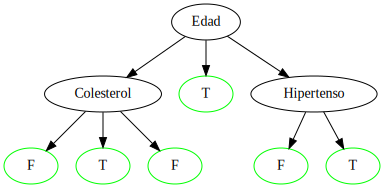

In [263]:

graph 

# Sandbox de pruebas

In [ ]:
setCases = SetCases(df,10,'ProblemasCardiacos')
#setCases.gain()
setCases.separate_data('Hipertenso')[1].head()
#setCases.entropy_attribute()
#print(setCases.most_frequent_class())

,index,Hipertenso,Colesterol,Trigliceridos,Edad,Diabeico,ProblemasCardiacos
0,1,T,bajo,elevado,menos_40,T,F
1,2,T,bajo,elevado,mayor_60,T,T
2,3,T,medio,elevado,mayor_60,F,T
3,6,T,alto,normal,entre_40_60,T,T
4,7,T,alto,normal,entre_40_60,T,T


In [ ]:
a = pd.DataFrame({'a':[1,2,3]})
b = pd.DataFrame({'b':[2,3,4]})

In [ ]:
list(df['ProblemasCardiacos'].unique())

['F', 'T']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a66d969-af84-4258-a4a2-724e61aa71b5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>